In [214]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

import time
from numba import jit, njit

from pprint import pprint
from rouge import Rouge

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

In [86]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',')

In [87]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [88]:
from sklearn.model_selection import train_test_split

In [204]:
train, test = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)

In [205]:
train, val = train_test_split(train, test_size=0.1765, random_state=42, shuffle=True)

In [206]:
train.shape

(695, 2)

In [207]:
test.shape

(150, 2)

In [208]:
val.shape

(150, 2)

In [209]:
def calc_vocab(texts) :
    vocab = [] 
    for text in texts:
        words = text.split()
        for w in words:          
            if w not in vocab:
                vocab.append(w)
    return len(vocab)

In [210]:
vocab = calc_vocab(train['text'])

In [211]:
vocab

10907

In [215]:
maxlen = 100
embed_dim = 150
batch_size = 64

In [216]:
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(train['text'])
seqs = tokenizer.texts_to_sequences(train['text'])
pad_seqs = pad_sequences(seqs, maxlen)

seqs_val = tokenizer.texts_to_sequences(val['text'])
pad_seqs_val = pad_sequences(seqs_val, maxlen)

In [217]:
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(vocab, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
state_h = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM'))(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [218]:
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(vocab, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

In [219]:
seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 100)               0         
_________________________________________________________________
Encoder-Model (Model)        (None, 256)               1921746   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 100, 256)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
Final-Output-Dense-before (D (None, 100, 10907)        2803099   
Total params: 5,119,085
Trainable params: 5,119,085
Non-trainable params: 0
_________________________________________________________________


In [220]:
seq2seq_Model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1,
                   patience = 2)

mc = ModelCheckpoint('best_model.h5',
                    monitor = 'val_loss',
                    mode = 'min',
                    verbose = 1,
                    save_best_only = True)

In [221]:
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1), 
                            batch_size=64, 
                            callbacks = [es, mc],
                            epochs=10,
                            validation_data = (pad_seqs_val, np.expand_dims(pad_seqs_val, -1)))

Train on 695 samples, validate on 150 samples
Epoch 1/10
695/695 [==============================] - 88s 126ms/step - loss: 8.1097 - val_loss: 7.1188

Epoch 00001: val_loss improved from inf to 7.11884, saving model to best_model.h5
Epoch 2/10
695/695 [==============================] - 84s 121ms/step - loss: 7.0361 - val_loss: 6.9180

Epoch 00002: val_loss improved from 7.11884 to 6.91798, saving model to best_model.h5
Epoch 3/10
695/695 [==============================] - 79s 114ms/step - loss: 6.8992 - val_loss: 6.8794

Epoch 00003: val_loss improved from 6.91798 to 6.87940, saving model to best_model.h5
Epoch 4/10
695/695 [==============================] - 82s 118ms/step - loss: 6.8470 - val_loss: 6.8777

Epoch 00004: val_loss improved from 6.87940 to 6.87771, saving model to best_model.h5
Epoch 5/10
695/695 [==============================] - 83s 120ms/step - loss: 6.8105 - val_loss: 6.8827

Epoch 00005: val_loss did not improve from 6.87771
Epoch 6/10
695/695 [=======================

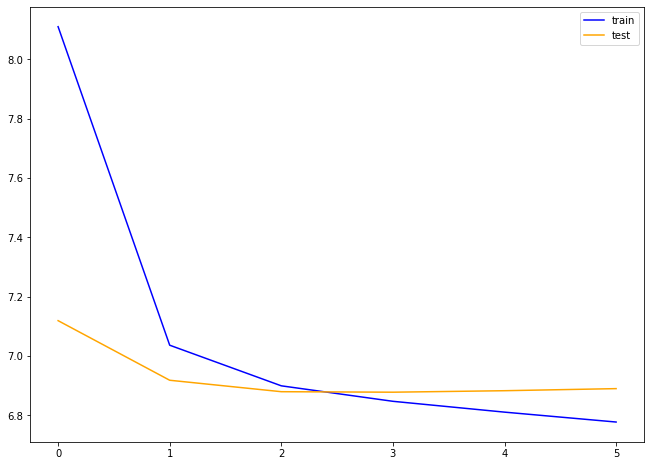

In [222]:
from matplotlib import pyplot
pyplot.figure(figsize = (11,8))
pyplot.plot(history.history['loss'], label = 'train', color = 'blue')
pyplot.plot(history.history['val_loss'], label = 'test', color = 'orange')

pyplot.legend()
pyplot.show()

In [223]:
def get_scores_rouge(text, prediction):
    rouge = Rouge()
    scores = rouge.get_scores(prediction, text)
    return scores

In [224]:
def get_predicted_text(text, maxlen=maxlen):
    seqs = tokenizer.texts_to_sequences([text])
    pad_seqs = pad_sequences(seqs, maxlen)
    res = seq2seq_Model.predict(pad_seqs)
    ty = tokenizer.sequences_to_texts(pad_seqs)
    rr = ' '.join(ty)
    return rr

In [225]:
pred = get_predicted_text(list(test['text'])[0])

In [226]:
pred

'want get closer sometimes boy want kiss might uncertain feeling make move give hint want kiss may need laugh joke ask spend time let know think thing say funny fun spending time really like shirt today look good whenever see tell joke sure show best come smile try grin look flirtatiously time help boost confidence kiss show interested playfully touch hand shoulder face touch signal want get closer greet part way give long tight hug give deep eye contact look lip alert may kiss mind look kiss look lip whole time keep move eye contact eye lip back eye talk'

In [227]:
list(test['text'])[0]

'first step get boy kiss friendly welcome already friend introduce try regularly communicate create closer relationship allow develop physical feeling youtry keep conversation light fun want desirable person spend time want get closer sometimes boy want kiss might uncertain feeling make move give hint want kiss may need laugh joke ask spend time let know think cutehere thing say funny fun spending time really like shirt today look good whenever see tell joke sure show best come hither smile try grin look flirtatiously time help boost confidence kiss show interested playfully touch hand shoulder face touch signal want get closer greet part way give long tight hug give deep eye contact look lip alert may kiss mind look kiss look lip whole time keep move eye contact eye lip back eye talk'

In [228]:
pprint(get_scores_rouge(list(test['text'])[0], pred))

[{'rouge-1': {'f': 0.8620689606123663, 'p': 1.0, 'r': 0.7575757575757576},
  'rouge-2': {'f': 0.8434782559663516,
              'p': 0.9797979797979798,
              'r': 0.7404580152671756},
  'rouge-l': {'f': 0.8711656392547706, 'p': 1.0, 'r': 0.7717391304347826}}]


In [229]:
pred = get_predicted_text(list(train['text'])[0])

In [230]:
pred

'try find common interest example may ask question music like tv watch might make comment like oh love pineapple pizza youre chat may try express he interested ask youre interested ask boyfriend may also ask friend question check may help decide whether he example say something another guy hot goodlooking speaks may show he little jealous offer ride home brings coffee snack without ask may express interest pay attention though also offer favor everyone else may friendly guy'

In [231]:
list(train['text'])[0]

'try find common interest example may ask question music like tv watch might make comment like oh love pineapple pizza youre chat may try express he interested ask youre interested ask boyfriend may also ask friend question check may help decide whether he example say something another guy hot goodlooking speaks may show he little jealous offer ride home brings coffee snack without ask may express interest pay attention though also offer favor everyone else may friendly guy'

In [232]:
pprint(get_scores_rouge(list(train['text'])[0], pred))

[{'rouge-1': {'f': 0.999999995, 'p': 1.0, 'r': 1.0},
  'rouge-2': {'f': 0.999999995, 'p': 1.0, 'r': 1.0},
  'rouge-l': {'f': 0.999999995, 'p': 1.0, 'r': 1.0}}]


In [249]:
def rouge_min(texts, rouge, metric):
    min_s = np.inf
    for text in texts:
        score = get_scores_rouge(text, get_predicted_text(text))[0].get(rouge).get(metric)
        if score < min_s:
            min_s = score
    return min_s

In [250]:
rouge_min(list(test['text']), 'rouge-l', 'p')

1.0

In [251]:
rouge_min(list(test['text']), 'rouge-l', 'r')

0.124

In [252]:
rouge_min(list(test['text']), 'rouge-l', 'f')

0.2206405674320234